# Choose your flight  with....
<img src="FlySmartlogo.png">

## Brought to you by Akanksha Gupta, Chaoyun Bao, Isabel Izquierdo, Rachel Serwetz and Xixin Liu

## First of all, we need to setting up the environment

#### <font color='red'>Please execute the block below when first starting the jupyterhub server. Then comment it out and restart the Kernel</font>

In [0]:
# Execute the following commands every time starting the server, once installed, reboot the kernel
#!sudo apt-get -y install libgeos-dev libgeos++-dev python3-mpltoolkits.basemap
#!sudo pip3 install -U pysal

#### Now you are set to go starting from here!

In [0]:
# Render our plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon

# Make the graphs a bit bigger
matplotlib.style.use(['seaborn-talk', 'seaborn-ticks', 'seaborn-whitegrid'])

from sqlalchemy import create_engine
conn_string = 'mysql://{user}:{password}@{host}:{port}/{db}?charset=utf8'.format(
    user='student', 
    password='dwdstudent2015', 
    host = 'db.ipeirotis.org', 
    port=3306, 
    db='public',
    encoding = 'utf-8'
)
engine = create_engine(conn_string)

# What worries you when you're going to travel?
<img src="questions_to_analyze.png">

# let's look at some data !!
<img src="data.jpg">

## Flight Data
We downloaded the flight on-time performance data published monthly by Beaureau of Transportation Statistics. For this project we used data in 2018 Q1. Below is an example of how we downloaded the data and uploaded to the SQL database at [db.ipeirotis.org](https://db.ipeirotis.org). This data is stored in the public.flightdata_TeamD table. 

In [0]:
## Example of downloading monthly data from BTS

#!mkdir -p data
#!curl 'https://transtats.bts.gov/PREZIP/On_Time_On_Time_Performance_2018_1.zip' -o data/flight_data_2018_1.zip
#!unzip data/*.zip 
#!mv *.csv data/flight_data_2018_1.csv
#!gzip data/flight_data_2018_1.csv
#!rm -f data/*.csv
#!rm -f data/*.zip

In [0]:
## Uploading the data to the SQL database
## The 2018 Q1 combined data has ~1.8 million rows and takes a while to upload

#csv_list = ["data/flight_data_2018_1.csv.gz","data/flight_data_2018_2.csv.gz","data/flight_data_2018_3.csv.gz"]

#for csv in csv_list:
#    df_flight = pd.read_csv(csv,encoding='utf_8',
#                          parse_dates = True,
#                          infer_datetime_format = True,
#                          low_memory=False)
#    df_flight.to_sql(name='FlightData_TeamD', # name the table "inspections"
#                     con=engine, # use the connection to MySQL created earlier
#                     if_exists='append', # if the table is already there, replace it
#                     index=False, # do not write the index column in the database
#                     chunksize=1000 # write 1000 lines at a time
#                    )

## Weather Data
Since OpenWeatherMap does not offer free API for historical weather, we ordered some historical weather data (for free!) from NOAA. For this analysis we only used data from the weather station in NYC for all 3 regional airports (LGA, JFK, EWR). Below is how we retrieved the data and uploaded to the database. The data is stored in the public.WeatherData_TeamD table.

In [0]:
#!curl 'https://www.ncei.noaa.gov/orders/cdo/1375261.csv' -o data/nyc_historical_data.csv
#!gzip data/nyc_historical_weather_data.csv

#weather_data = pd.read_csv("data/nyc_historical_weather_data.csv.gz", 
#                          encoding='utf_8',
#                          parse_dates = True,
#                          infer_datetime_format = True,
#                          low_memory=False)

#weather_data.DATE = pd.to_datetime(weather_data.DATE)

#weather_data.to_sql(name='WeatherData_TeamD', # name the table "inspections"
#                   con=engine, # use the connection to MySQL created earlier
#                   if_exists='replace', # if the table is already there, replace it
#                   index=False, # do not write the index column in the database
#                   chunksize=1000 # write 1000 lines at a time
#)

## Airport Metadata
We also used airport longitude and latitude data for creating the flight route map. Since this is a fairly small dataset and only used in part of our analysis, it is downloaded to local directory and read in to the notebook directly from there.

In [0]:
# airport IATA code to lat and lon
!mkdir -p data
!curl 'http://ourairports.com/data/airports.csv' -o data/airports.csv

airports = pd.read_csv("data/airports.csv",low_memory=False)
usairports = airports[(airports.iata_code.notna()) & 
                      (airports.iso_country == 'US')][['iata_code','latitude_deg','longitude_deg']]

UnboundLocalError: local variable 'child' referenced before assignment

## Airline code to name

Since the airline is denoted as the code in the on-time performance data, we created the following look-up table for airline code to full name. The data is from [IATA webpage](http://www.iata.org/publications/Pages/code-search.aspx).


In [0]:
airline_dictionary = {'9E': 'Pinnacle Airlines', 
              'AA': 'American Airlines', 
              'AS': 'Alaska Airlines',
              'B6': 'JetBlue',
              'DL': 'Delta Air Lines',
              'EV': 'Atlantic Southeast Airlines',
              'F9': 'Frontier Airlines',
              'G4': 'Allegiant Air',
              'HA': 'Hawaiian Airlines',
              'MQ': 'Envoy Air',
              'NK': 'Spirit Airlines',
              'OH': 'Comair',
              'OO': 'SkyWest  Airlines',
              'UA': 'United Airlines',
              'VX': 'Virgin America',
              'WN': 'Southwest Airlines',
              'YV': 'Mesa Airlines',
              'YX': 'Midwest Airlines'
             }

# Looking at airlines.....  
<img src="Airline.png">

In [0]:
# Number of flights per Carrier
query = '''SELECT Carrier, FlightNum AS Num_flights
FROM FlightData_TeamD
'''

df_airline = pd.read_sql(query, con=engine)
df_airline["Carrier"].replace(airline_dictionary, inplace=True)
pivot= pd.pivot_table(data = df_airline, # Analyze the restaurants dataset
        index = 'Carrier', 
        values = 'Num_flights',
        aggfunc = 'count').sort_values(by= ['Carrier'])


# Number of delayed flights per Carrier
query = '''SELECT Carrier, DepDel15 AS Num_Delays
FROM FlightData_TeamD WHERE DepDel15 = 1
'''

df_airline_delays = pd.read_sql(query, con=engine)
df_airline_delays["Carrier"].replace(airline_dictionary, inplace=True)

#Create pivot to count number of delayed flights per airline
pivot1= pd.pivot_table(data = df_airline_delays, # Analyze the restaurants dataset
        index = 'Carrier', 
        values = 'Num_Delays',
        aggfunc = 'count').sort_values(by= ['Carrier'])

#create a pivot combining pivot1 and pivot
pivot2 = pd.merge(pivot, pivot1, how='left', on='Carrier', left_index=False, right_index=False, suffixes=('_x', '_y'), copy=False)
pivot2['ratio'] = (pivot2.Num_Delays/pivot2.Num_flights).round(3)*100

#now sort the pivot by the carrier with most flights
pivot2_sorted = pivot2.sort_values(by='ratio', ascending=False)

pivot2_sorted


In [0]:
# Create the plot showing airline delay ratio

pivot3_sorted = pivot2.sort_values(by='Num_flights', ascending=False)
Carrier1 = pd.DataFrame(pivot3_sorted['ratio'])


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
pivot3_sorted.plot(kind='bar',ax=ax1,figsize=(12,8))
ax1.grid(False)
Carrier1.plot(color='g',ax=ax2)
ax2.legend().set_visible(False)

plt.show()

### so....  the airlines with most delayed flights during the first quarter of 2018 are .....
<img src="most_delayed.png">

# How about airports ? 
 <img src="Airport.png">

In [0]:
#num flights per origin

query = '''
SELECT  origin, FlightNum AS num_flights
from public.FlightData_TeamD
'''

df_numflights = pd.read_sql(query, con=engine)
df_numflights

pivot= pd.pivot_table(data = df_numflights,
       index = 'origin',
       values = 'num_flights',
       aggfunc = 'count')

In [0]:
#Which airport shows longer delays (bar plot)
#This query takes a bit time to run, please be patient

query = '''
select origin, sum(DepDelayMinutes) AS length_delays, avg(DepDelayMinutes) AS averagelength_delays
from public.FlightData_TeamD
where DepDelayMinutes>0
GROUP BY origin
ORDER BY averagelength_delays DESC
limit 20
'''

df = pd.read_sql(query, con=engine)
df.sort_values(by='averagelength_delays',ascending=False).plot(kind='bar', x='origin', y='averagelength_delays')

In [0]:
#Which airport shows more delays (bar plot) where delays are over 15 minutes
#DepDel15 is counted as 1 
#This query takes a bit time to run, please be patient

query = '''
select origin, sum(DepDel15) AS num_delays, avg(DepDel15) as averagenum_delays
from public.FlightData_TeamD
GROUP BY origin
ORDER BY averagenum_delays DESC
limit 20
'''

df_numdelays = pd.read_sql(query, con=engine)
df_numdelays.sort_values(by='averagenum_delays',ascending=False).plot(kind='bar', x='origin', y='averagenum_delays')

In [0]:
#normalization check

pivot2 = pd.merge(df_numdelays, pivot, how='left', on='origin', left_index=False, right_index=False, suffixes=('_x', '_y'), copy=False)

pivot2['ratio'] = pivot2.num_delays/pivot2.num_flights

pivot2.head()

# and the delays by routes are .....  !
<img src="Route.png">

## First, let's get flight departure and arrival delay data from the database

In [0]:
query = '''
select FlightDate,UniqueCarrier,TailNum,FlightNum,Origin,Dest,DepDelay,DepDelayMinutes,ArrDelay,ArrDelayMinutes
from FlightData_TeamD
'''
flightdata = pd.read_sql(query,con=engine)
usairports = usairports[usairports.iata_code.isin(set(flightdata.Dest))]

## Then, compute average delay of each route
Here we created two functions allowing user to select which airport to compute the delay statistics for and whether they want to calculate departure or arrival delay. For future improvement we would check whether airport code provided by the user is valid or not.


In [0]:
def delay_by_airport(df,airport='all',origin=True):
  # function to compute average route delay for user defined list of airport(s)
  # if origin is set to true, delays are computed for flights departing from the airport
  # if origin is set to false, delays are computed for fiights arriving at the airport
  
    if (airport == 'all'):
        airport_data = df
    else:
        if origin:
            airport_data = df[df.Origin.isin(airport)]
        else:
            airport_data = df[df.Dest.isin(airport)]
    airport_pivot = pd.pivot_table(
        data = airport_data,
        index = ['Origin','Dest'],
        values = ['DepDelay','DepDelayMinutes','ArrDelay','ArrDelayMinutes'],
        aggfunc = ['mean','count']
    ).reset_index()
    new_cols = [''.join(t) for t in airport_pivot.columns]
    airport_pivot.columns = new_cols
    
    flights = pd.merge(airport_pivot, usairports, how='left', left_on='Origin', right_on='iata_code',
                           left_index=False, right_index=False, suffixes=('_x', '_y'), copy=False).drop(columns='iata_code')
    flights.rename(columns={'latitude_deg': 'Origin_lat', 'longitude_deg': 'Origin_lon'}, inplace=True)
    
    flights = pd.merge(flights, usairports, how='left', left_on='Dest', right_on='iata_code',
                           left_index=False, right_index=False, suffixes=('_x', '_y'), copy=False).drop(columns='iata_code')
    flights.rename(columns={'latitude_deg': 'Dest_lat', 'longitude_deg': 'Dest_lon'}, inplace=True)
    return(flights)

## Last step: plot the flight route map
This is where the fun begins:

In [0]:
def plot_flight_path(df,df_field,color_range=[0.,30.],plottitle=""):
  # function to plot flight route map with specific color coding
  # df_field: column in df which the color of the route line is based on
  # color_range: range of values the colormap is going to represent for df_field
  # plottitle: customized plot title if wanted
  
    fig = plt.figure(figsize=(15, 10))
    ax0 = plt.subplot2grid((15, 1), (0, 0), rowspan=14,colspan=1)
    m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
                projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
    m.drawmapboundary(fill_color='white')
    m.drawcountries()
    m.drawcoastlines()
    m.drawstates()
    for index,airport in usairports.iterrows():
        x,y = m(airport['longitude_deg'], airport['latitude_deg'])
        m.scatter(x,y,marker='o', color='grey',s = 10)
    df['plotcolor'] = (color_range[1]-df[df_field])/(color_range[1]-color_range[0])
    cmap = plt.cm.RdBu
    for index,route in df.iterrows():
        try:
            m.drawgreatcircle(route['Origin_lon'],route['Origin_lat'],route['Dest_lon'],route['Dest_lat'],
                  color=cmap(route['plotcolor']),linewidth=0.7)#,alpha=route['plotcolor'])
        except (ValueError, IndexError):
            pass
    plt.title(plottitle)
    ax1 = plt.subplot2grid((15, 1), (14, 0))
    
    cmap = matplotlib.cm.RdBu_r
    norm = matplotlib.colors.Normalize(vmin=color_range[0], vmax=color_range[1])
    
    cb1 = matplotlib.colorbar.ColorbarBase(ax1, cmap=cmap,norm=norm,orientation='horizontal')
    cb1.set_label(df_field)
    
    plt.show()

## Let's see how NYC airports are doing in terms of departure delays

In [0]:
lga_delay = delay_by_airport(flightdata,airport=['LGA'],origin=True)
plot_flight_path(lga_delay,'meanDepDelay',plottitle='LGA Departure Average Delay')

In [0]:
jfk_delay = delay_by_airport(flightdata,airport=['JFK'],origin=True)
plot_flight_path(jfk_delay,'meanDepDelay',plottitle='JFK Departure Average Delay')

In [0]:
ewr_delay = delay_by_airport(flightdata,airport=['EWR'],origin=True)
plot_flight_path(ewr_delay,'meanDepDelay',plottitle='EWR Departure Average Delay')

## Of course, if we want to see the plain data table

In [0]:
lga_delay.sort_values('meanDepDelay',ascending = False).head(10)
#jfk_delay.sort_values('meanDepDelay',ascending = False).head(10)
#ewr_delay.sort_values('meanDepDelay',ascending = False).head(10)

# but don't forget to check the weather...  
<img src="weather.png">

## Let's join Flight data and Weather data from Database

In [0]:
#This query takes a bit time to run, please be patient

combine='''
SELECT F.FlightNum,F.Carrier,F.DepDel15,F.DepDelayMinutes,W.HOURLYVISIBILITY, W.HOURLYWETBULBTEMPC, 
W.HOURLYRelativeHumidity, W.HOURLYWindSpeed, W.HOURLYWindGustSpeed,
W.HOURLYStationPressure,W.DATE
FROM WeatherData_TeamD W
INNER JOIN FlightData_TeamD F
ON DATE(W.DATE) = F.FlightDate AND HOUR(W.DATE) =ceil(F.CRSDepTime/100)
WHERE F.OriginCityName = "New York, NY";
'''
clean = pd.read_sql(combine, engine)

In [0]:
#clean the data, change the attributes

clean["Carrier"].replace(airline_dictionary, inplace=True)
clean['DepDel15'].replace({0:'Ontime',1:'Delayed'},inplace=True)
clean=clean.dropna()
clean.columns=['FlightNum', 'Carrier','Delay','DelayMinutes','Visability','Temperature','Humidity','WindSpeed','WindGust'
              ,'Pressure','Date']

## Then, take a look at the scatter plot to find relationships between weather and flight delay

In [0]:
# Use heatmap to visualize the correlation
sns.heatmap(clean.corr())

In [0]:
df=clean[['Delay','Temperature','DelayMinutes','Humidity','Carrier']]
sns.pairplot(df, hue="Carrier")

In [0]:
#tempreture and delay
sns.lmplot("Temperature","DelayMinutes",data=df, hue='Carrier')

In [0]:
#humidity and delay
sns.lmplot("Humidity","DelayMinutes",data=df, hue='Carrier')

# why are flights delayed ?
<img src="giphy.gif">

## What are the different types of flight delays?

In [0]:
query = '''
SELECT Carrier,
       sum(CarrierDelay)/60 AS carrier_delay_in_hours, 
       sum(WeatherDelay)/60 AS weather_delay_in_hours,
       sum(NASDelay)/60 AS nas_delay_in_hours,
       sum(SecurityDelay)/60 AS security_delay_in_hours,
       sum(LateAircraftDelay)/60 AS late_aircraft_delay_in_hours 

FROM FlightData_TeamD
WHERE CarrierDelay IS NOT NULL AND
      WeatherDelay IS NOT NULL AND
      NASDelay IS NOT NULL AND
      SecurityDelay IS NOT NULL AND
      LateAircraftDelay IS NOT NULL
GROUP BY Carrier;
'''
df_delay = pd.read_sql(query, con=engine)
df_delay.dtypes

# Note: NAS = National Air System Delay

# DESCRIBES ALL THE DELAYS
# https://www.bts.gov/explore-topics-and-geography/topics/airline-time-performance-and-causes-flight-delays


# Prints out total number of hours of delay caused by each of the above factors for each airlines
df_delay["Carrier"].replace(airline_dictionary, inplace=True)
df_delay.head()

,Carrier,carrier_delay_in_hours,weather_delay_in_hours,nas_delay_in_hours,security_delay_in_hours,late_aircraft_delay_in_hours
0,Pinnacle Airlines,3999.250000,1260.233333,2848.000000,4.966667,4754.733333
1,American Airlines,12017.816667,1520.950000,7844.983333,56.850000,11750.116667
2,Alaska Airlines,1117.916667,143.983333,1502.300000,22.416667,1078.983333
3,JetBlue,8232.066667,475.850000,3985.016667,45.966667,9183.266667
4,Delta Air Lines,10810.700000,3982.900000,7440.883333,25.300000,8683.783333


Text(0,0.5,'Hours Delayed')

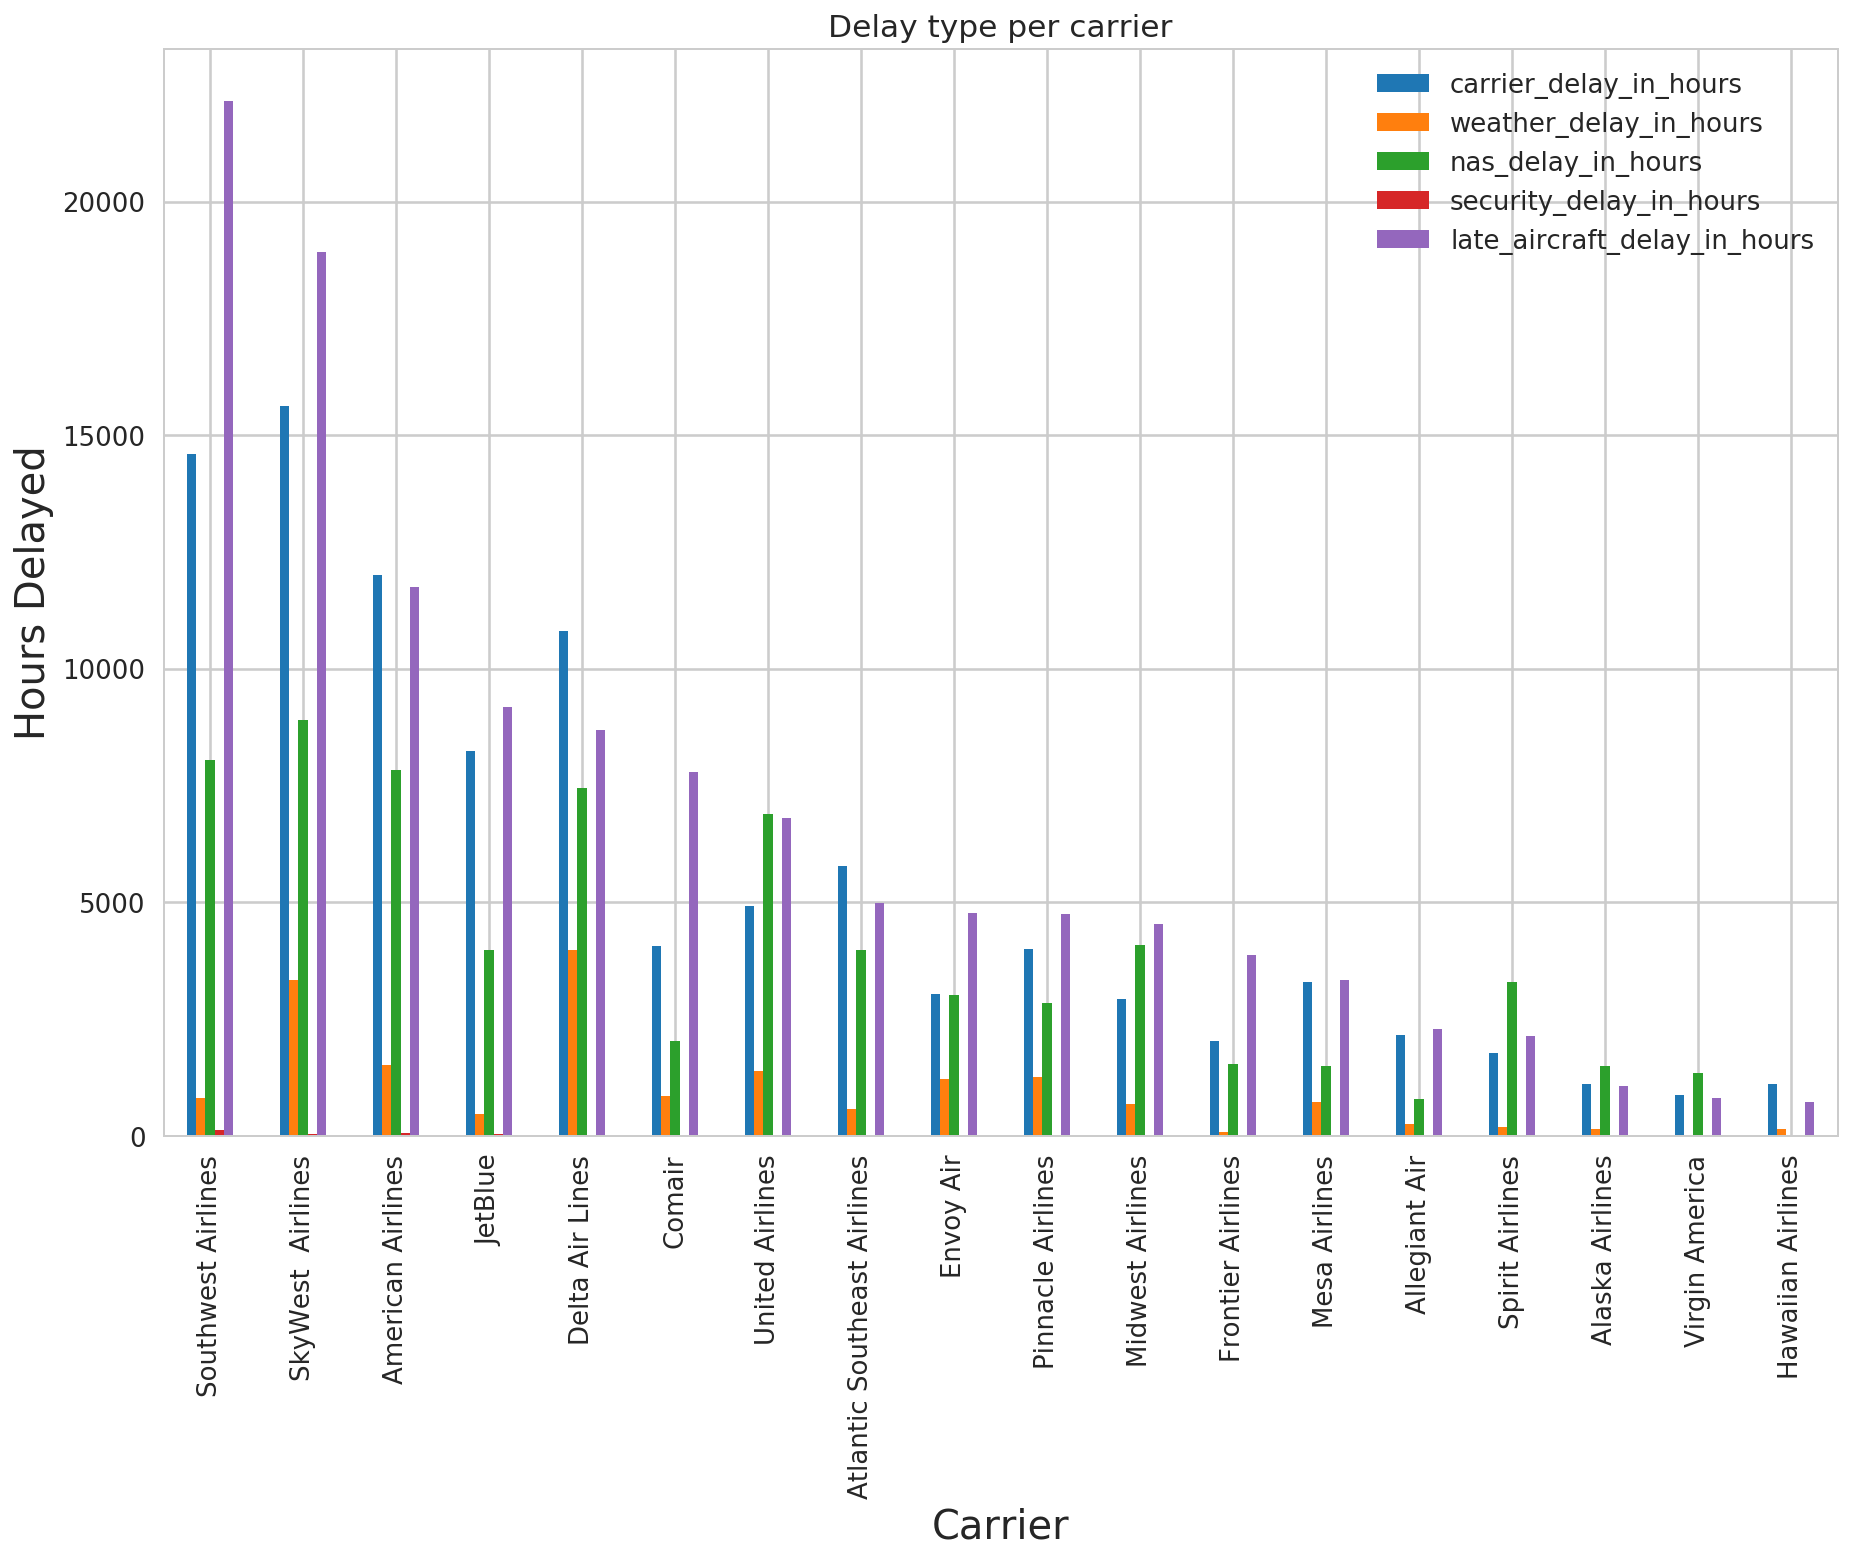

In [0]:
# Southwest has maximum number of hours of delay caused by late aircraft arrival
df_delay.sort_values('late_aircraft_delay_in_hours', inplace=True, ascending=False)
df_delay.reset_index(drop=True)
df_delay

plot_this = df_delay.plot.bar(x='Carrier', sharey=True, sharex=True, figsize = (15,10), title='Delay type per carrier')
plot_this.set_xlabel("Carrier", size = 20)
plot_this.set_ylabel("Hours Delayed", size = 20)

#### A few take aways
 - Southwest caused most number of hours of carrier delays; Skywest & American were close second
 - Delta had most weather delays followed by skywest
 - Lot of airlines had National Air Space delays
 - Southwest had unusually high number of security delays
 - Southwest had most total number of hours delay due to late arrival of an aircraft


In [0]:
# Above query sum all the hours of delay to identify most severe delay type

new_names = {'index':'Delay_Type', 0:'Hours'}
df_total = df_delay.drop(columns=['Carrier']).sum(axis=0).reset_index().rename(index=str, columns=new_names)
df_total.sort_values(by='Hours', ascending=False)

,Delay_Type,Hours
4,late_aircraft_delay_in_hours,118619.583333
0,carrier_delay_in_hours,98435.466667
2,nas_delay_in_hours,69110.100000
1,weather_delay_in_hours,17754.966667
3,security_delay_in_hours,471.300000


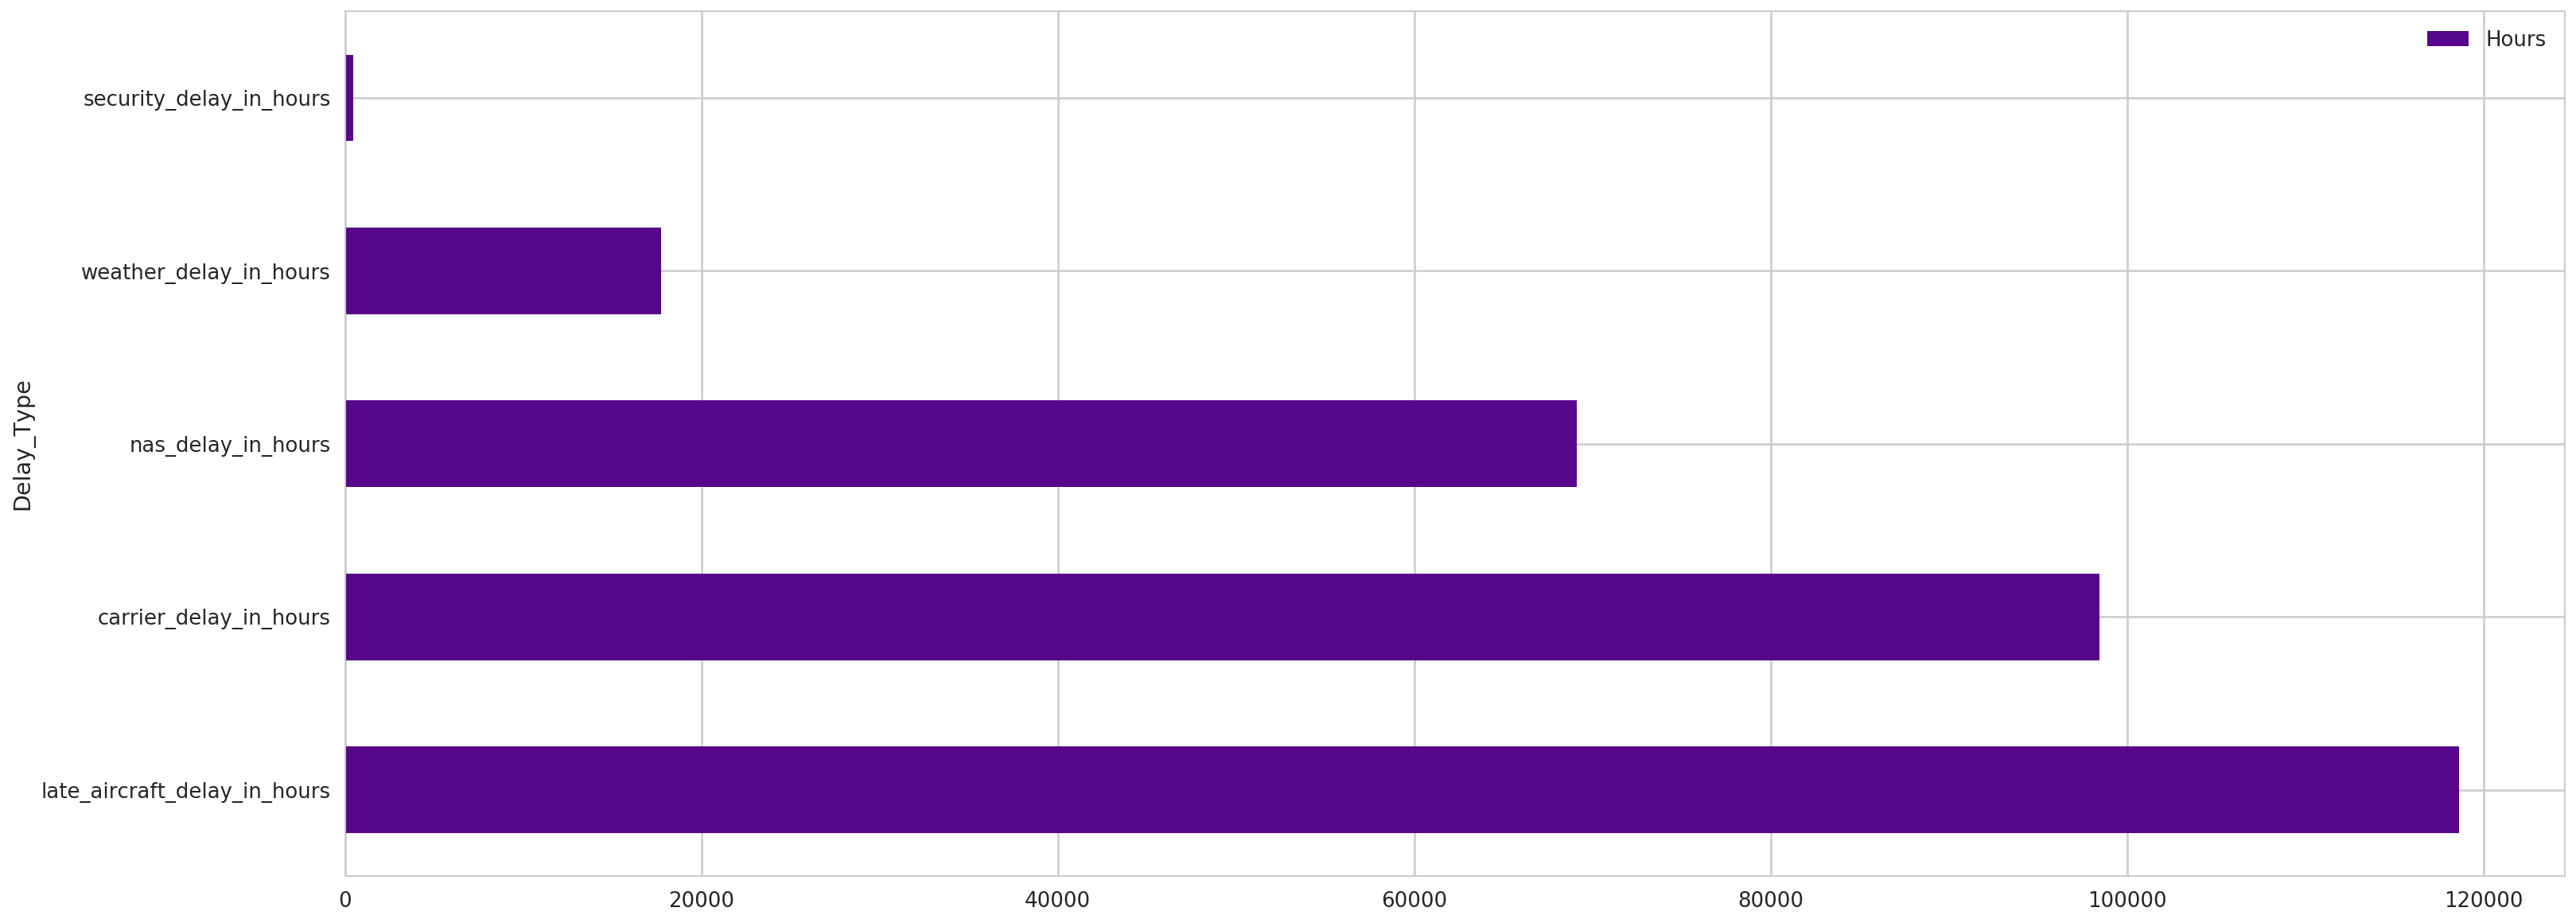

In [0]:
# Plot the graph
df_total.sort_values(by='Hours', ascending=False).plot(kind='barh', x='Delay_Type', figsize=(25, 10), grid=True, color='#57068c')


## Count total number of delays by each carrier

In [0]:
query = '''
SELECT Carrier,
       CarrierDelay,
       WeatherDelay,
       NASDelay,
       SecurityDelay,
       LateAircraftDelay
        
FROM FlightData_TeamD
WHERE CarrierDelay IS NOT NULL AND
      WeatherDelay IS NOT NULL AND
      NASDelay IS NOT NULL AND
      SecurityDelay IS NOT NULL AND
      LateAircraftDelay IS NOT NULL;
'''
df = pd.read_sql(query, con=engine)

In [0]:
pivot_carrier = pd.DataFrame(df[df.CarrierDelay > 0.0].pivot_table(index = 'Carrier', values = 'CarrierDelay', aggfunc = 'count'))
pivot_carrier.fillna(0, inplace=True)
pivot_carrier.reset_index( inplace=True)


pivot_weather = pd.DataFrame(df[df.WeatherDelay > 0.0].pivot_table(index = 'Carrier', values = 'WeatherDelay', aggfunc = 'count'))
pivot_weather.fillna(0, inplace=True)
pivot_weather.reset_index( inplace=True)

pivot1 = pd.merge(pivot_carrier, pivot_weather, 'left', on = ["Carrier"] )
pivot1

pivot_nas = pd.DataFrame(df[df.NASDelay > 0.0].pivot_table(index = 'Carrier', values = 'NASDelay', aggfunc = 'count'))
pivot_nas.fillna(0, inplace=True)
pivot_nas.reset_index( inplace=True)

pivot_security = pd.DataFrame(df[df.SecurityDelay > 0.0].pivot_table(index = 'Carrier', values = 'SecurityDelay', aggfunc = 'count'))
pivot_security.fillna(0, inplace=True)
pivot_security.reset_index( inplace=True)

pivot2 = pd.merge(pivot_nas, pivot_security, 'left', on = ["Carrier"] )
pivot2.fillna(0, inplace=True)
pivot2

pivot_lateaircraft = pd.DataFrame(df[df.LateAircraftDelay > 0.0].pivot_table(index = 'Carrier', values = 'LateAircraftDelay', aggfunc = 'count'))
pivot_lateaircraft.fillna(0, inplace=True)
pivot_lateaircraft.reset_index( inplace=True)

pivot3 = pd.merge(pivot1, pivot2, 'left', on = ["Carrier"] )
pivot4 = pd.merge(pivot3, pivot_lateaircraft, 'left', on = ["Carrier"] )

pivot4.fillna(0, inplace=True)
pivot4

pivot4["Carrier"].replace(airline_dictionary, inplace=True)
pivot4


,Carrier,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,Pinnacle Airlines,4208,735,5433,6.0,5100
1,American Airlines,18446,2355,19453,152.0,14446
2,Alaska Airlines,1599,190,3964,64.0,1534
3,JetBlue,14785,437,10171,124.0,11343
4,Delta Air Lines,14052,3464,14283,24.0,10844
5,Atlantic Southeast Airlines,4881,322,6538,0.0,5327
6,Frontier Airlines,3225,145,3601,0.0,3100
7,Allegiant Air,2354,281,2530,55.0,2654
8,Hawaiian Airlines,2439,263,150,20.0,1576
9,Envoy Air,5263,1984,7882,37.0,6666


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5bd99b1cc0>],
      dtype=object)

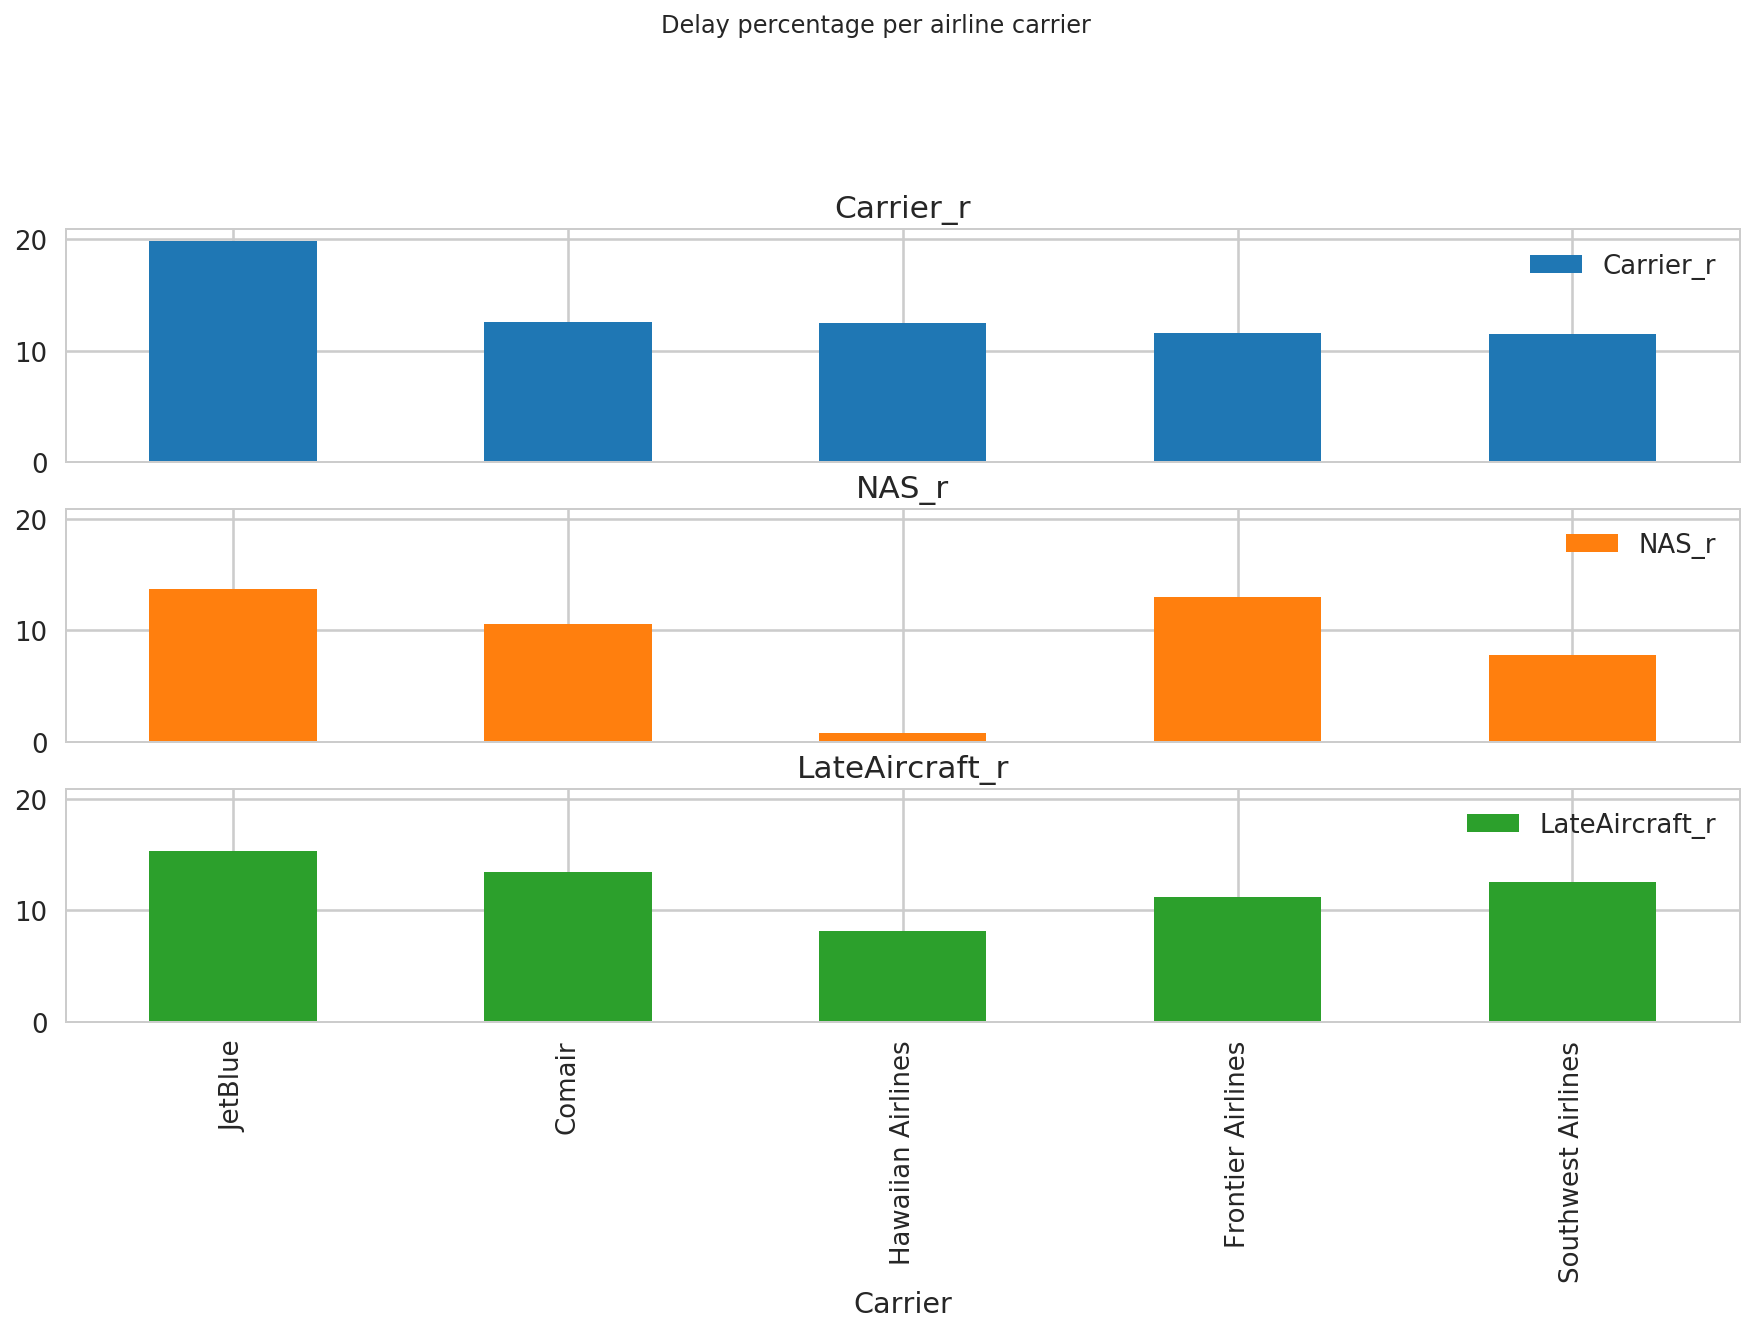

In [0]:
# Number of flights per Carrier
query = '''SELECT  Carrier, FlightNum AS Num_flights
FROM FlightData_TeamD;'''

df_airline = pd.read_sql(query, con=engine)
df_airline["Carrier"].replace(airline_dictionary, inplace=True)
df_airline
pivot= pd.pivot_table(data = df_airline,
                    index = 'Carrier', 
                    values = 'Num_flights',
                    aggfunc = 'count').sort_values(by= ['Carrier'])

#create a pivot combining pivot4 and pivot
pivot2 = pd.merge(pivot4, pivot, how='left', on='Carrier', left_index=False, right_index=False, suffixes=('_x', '_y'), copy=False)

#Normalize the data
pivot2['Carrier_r'] = (pivot2.CarrierDelay/pivot2.Num_flights).round(3)*100
pivot2['Weather_r'] = (pivot2.WeatherDelay/pivot2.Num_flights).round(3)*100
pivot2['NAS_r'] = (pivot2.NASDelay/pivot2.Num_flights).round(3)*100
pivot2['Security_r'] = (pivot2.SecurityDelay/pivot2.Num_flights).round(3)*100
pivot2['LateAircraft_r'] = (pivot2.LateAircraftDelay/pivot2.Num_flights).round(3)*100

# Add normalized values in the dataframe
df1 = pivot2[['Carrier','Carrier_r','Weather_r', 'NAS_r', 'Security_r', 'LateAircraft_r']]

# Make a deep copy so that changing either of the data frame doesn't affect the other dataframe
import copy
df2 = copy.deepcopy(df1)

# Picking only three delays to plot because weather and security delays are not that often
df2 = df2[['Carrier','Carrier_r', 'NAS_r', 'LateAircraft_r']]
df2.sort_values('Carrier_r', inplace=True,ascending=False)
df2.reset_index(drop=True)
df2 = df2.head()

#sns.pairplot(df2,hue='Carrier')
df2.plot(kind= 'bar',subplots = True, layout = (6,1), 
       figsize = (15,15), x='Carrier', sharex = True, sharey = True,
       grid=True, title='Delay percentage per airline carrier')

#### Key takeaways
- Late aircraft arrivals (not weather) causes most number of delays
